# [WSI] Ćwiczenie nr 2
### Algorytmy ewolucyjne

Mikołaj Wewiór 318407


## pytania

-> funkcja dopasowania </br>
-> złożoność obliczeniowa - na dole pierwszej strony polecenia </br>
-> czy mutacja może dawać gorsze wyniki </br> 
-> czy krzyżowanie może tylko brać na współrzędną X tylko x1 lub x2 i analogicznie dla Y, czy to może być losowa kombinacja z listy [x1, y1, x2, y2] </br>

In [133]:
import matplotlib.pyplot as plt
import numpy as np
import random
import copy


RAST_BOUNDS = [-5.12, 5.12]
GRIE_BOUNDS = [-50, 50]
DROP_BOUNDS = [-4, 4]
DIMENSIONS = 2


PLOT_STEPS = 200
PLOT_COLOR = "turbo"
PARTICLES_COLOR = 'white'
BEST_COLOR = "magenta"
# viridis # plasma # inferno # magma # cividis
# cubehelix # gist_earth # turbo # terrain


ITERATIONS = 1000
POPULATION = 25
PC = 0.4
PM = 0.7
SIGMA = 0.5
ELITE_SUCCESSION = 1


EVIL_GLOBAL_VAR = []


In [134]:
class Function:

    def __init__(self, bounds, dimensions, global_optimum=0.0):
        self._name = None
        self._bounds = bounds
        self._dimensions = dimensions
        self._global_optimum = global_optimum


    def name(self) -> str:
        return self._name

    def dimension(self) -> int:
        return self._dimensions

    def bounds(self) -> list:
        return self._bounds

    def bound(self) -> float:
        return max(self.bounds())

    def global_optimum(self) -> float:
        return self._global_optimum

    def get_bounds(self) -> tuple:
        return self.bounds()[0], self.bounds()[1]

    def q(self) -> float:
        pass


In [135]:
class Rastrigin(Function):

    def __init__(self, bounds, dimensions):
        super().__init__(bounds, dimensions)
        self._name = "Rastrigin"

    def q(self, x_vector) -> float:
        d = self.dimension()
        partial_cost = lambda x: x**2 - 10*np.cos(2*np.pi*x)

        cost = 10*d
        for i in range(d) : cost += partial_cost(x_vector[i])

        return cost


In [136]:
class Griewank(Function):

    def __init__(self, bounds, dimensions):
        super().__init__(bounds, dimensions)
        self._name = "Griewank"

    def q(self, x_vector) -> float:
        d = self.dimension()

        SUM = 0
        for i in range(d):
            SUM += x_vector[i]**2
        SUM = SUM / 4000

        PI = 1
        for i in range(d):
            PI = PI*np.cos(
                x_vector[i]*np.sqrt(i+1)/(i+1)
            )

        return SUM - PI + 1


In [137]:
class DropWave(Function):
    def __init__(self, bounds, dimensions, global_optimum=0.0):
        super().__init__(bounds, dimensions, global_optimum)
        self._name = "DropWave"

    def q(self, x_vector) -> float:
        d = self.dimension()

        square = 0
        for i in range(d):
            square += x_vector[i]**2

        numerator = 1 + np.cos(12*np.sqrt(square))
        denominator = 0.5 * square + 2

        return 1-numerator/denominator


In [138]:
class Quadratic(Function):

    def __init__(self, bounds, dimensions, global_optimum=0.0):
        super().__init__(bounds, dimensions, global_optimum)
        self._name = "Quadratic"


    def q(self, x_vector) -> float:
        d = self._dimensions

        cost = 0
        for i in range(d):
            cost += (x_vector[i])**2

        return cost

In [139]:
class Particle:
    def __init__(self, id: int, position: list, function: Function):
        self._id = id
        self._position = position
        self._function = function
        self._rank = None
        self.q = None

    def function(self) -> Function:
        return self._function

    def id(self) -> int:
        return self._id

    def position(self) -> list:
        return self._position

    def value(self) -> float:
        return self.q

    def rank(self) -> float:
        return self._rank

    def set_position(self, index, value):
        self._position[index] = value

    def set_positions(self, values):
        if len(values) == self.function().dimension():
            self._position = values

    def set_value(self):
        x = self.position()
        self.q = self.function().q(x)

    def set_rank(self, rank):
        self._rank = rank

    def fix_position(self):
        min_bound, max_bound = self.function().get_bounds()
        """Metoda naprawy rozwiązania przez zawijanie"""
        for d in range(self.function().dimension()):
            while self.position()[d] > max_bound:
                difference = self.position()[d] - max_bound
                self.set_position(d, min_bound + difference)
            while self.position()[d] < min_bound:
                difference = self.position()[d] - min_bound
                self.set_position(d, max_bound + difference)


    def print(self):
        print(f'{self.id()} | {self.position()} | {self.value()} | {self.function().name()}')

In [140]:
class Evolution:
    def __init__(self, function: Function, iterations: int, population_count: int, mutation_factor: float, crossing_factor: float, mutation_sigma: float = None, elite_succession : int = 1):

        def generate_population() -> list:
            bound = function.bound()
            population = []
            for id in range(population_count):
                x1 = np.random.uniform(-bound, bound)
                x2 = np.random.uniform(-bound, bound)
                particle = Particle(id+1, [x1, x2], function)
                particle.set_value()
                population.append(particle)
            return population

        self._function = function
        self._iterations = iterations
        self._population_count = population_count
        self._population = generate_population()
        self._mutation_factor = mutation_factor
        self._mutation_sigma = mutation_sigma
        self._crossing_factor = crossing_factor
        self._elite_successors = elite_succession
        self._current_best_fitness = None
        self._history_best_fitness = None


    def function(self) -> Function:
        return self._function

    def iterations(self) -> int:
        return self._iterations

    def pm(self) -> float:
        return self._mutation_factor

    def pc(self) -> float:
        return self._crossing_factor

    def sigma(self) -> float:
        return self._mutation_sigma

    def elites_count(self) -> int:
        return self._elite_successors

    def population(self) -> list:
        return self._population

    def nominal_population_count(self) -> int:
        return self._population_count

    def current_population_count(self) -> int:
        return len(self.population())

    def set_new_population(self, population):
        self._population = population

    def sort_population(self):
        self.population().sort(key = lambda p: p.value())
        self._current_best_fitness = self.population()[0]

    def best_fitness(self) -> Particle:
        return self._current_best_fitness

    def best_history_fitness(self) -> Particle:
        history_best = self._history_best_fitness
        if history_best is None:
            return self.best_fitness()
        return history_best

    def set_best_fitness(self, best_fitness):
        self._current_best_fitness = best_fitness
        if self._history_best_fitness is None:
            self._history_best_fitness = best_fitness
        elif best_fitness.value() < self._history_best_fitness.value():
            self._history_best_fitness = best_fitness


    def fitness_func(self):
        for particle in self.population():  particle.set_value()
        self.sort_population()

        best_fitness = self.best_history_fitness()
        best_fitness.set_rank(1)
        best_value = best_fitness.value()

        for particle in self.population()[1::]:
            r = 1 + (particle.value() - best_value)**2
            particle.set_rank(r)

        """if we would know global optimum at start:"""
        # for particle in self.population():
        #     r = 0
        #     for d in range(self.function.dimention()):
        #         r += particle.position()[d]**2
        #     particle.set_rank(np.sqrt(r))




    def crossover(self, first_parent: Particle) -> Particle:
        a = np.random.random()
        if a < self.pc():

            second_parent = random.choice(self.population())
            possible_position = []

            for parent in [first_parent, second_parent]:
                for d in range(self.function().dimension()):
                    possible_position.append(parent.position()[d])

            particle = Particle(first_parent.id(), [None, None], self.function())

            for d in range(self.function().dimension()):
                particle.set_position(d, random.choice(possible_position))

        else:
            particle = first_parent

        particle.fix_position()
        return particle


    def mutation(self, particle: Particle) -> Particle:
        a = np.random.random()
        if a < self.pm():
            for i in range(self.function().dimension()):
                mut = self.sigma() * np.random.randn()
                particle.position()[i] += mut
            particle.fix_position()
        return particle


    def reproduction(self):
        reproduction = []
        while( len(reproduction) < self.nominal_population_count() - self.elites_count()):
            particle1 = random.choice(self.population())
            particle2 = random.choice(self.population())

            if particle1.rank() <= particle2.rank():
                reproduction.append(copy.deepcopy(particle1))
            else:
                reproduction.append(copy.deepcopy(particle2))

        self.set_new_population(reproduction)


    def succession(self, new_population: list):
        for index in range(self.elites_count()):
            new_population.insert(index, self.best_fitness())
        self.set_new_population(new_population)





    # inicjalizacja populacji
    # wartość funkcji dopasowania dla osobnika
    #   wybór osobników do krzyżowania
    #   krzyżowanie
    #   mutacja wybranych
    #   obliczenie wartości funkcji dopasowania dla każdego
    #   wybór nowej populacji



In [141]:
class Plotter:
    def __init__(self, function: Function, steps: int, bounds: list = None):
        self._function = function
        self._steps = steps
        self._dimensions = function.dimension()
        self._bounds = bounds


    def funciton(self):
        return self._function

    def name(self):
        return self.funciton().name()

    def d(self):
        return self._dimensions

    def steps(self):
        return self._steps

    def bounds(self):
        if self._bounds != None:
            return self._bounds
        return self.funciton().bounds()

    def q(self, x_vector):
        return self.funciton().q(x_vector)


    def plot(self, drow_online = False):
        step = self.steps()
        bounds = self.bounds()
        diff = bounds[1] - bounds[0]

        Z = np.zeros((step+1, step+1))
        for i in range(step+1):
            y = bounds[0] + i*diff/step
            for j in range(step+1):
                x = bounds[0] + j*diff/step
                Z[i][j] = self.q([x, y])

        x = np.linspace(bounds[0], bounds[1], step+1)
        y = np.linspace(bounds[0], bounds[1], step+1)

        X, Y = np.meshgrid(x, y)

        plt.figure()
        plt.ion()

        contour = plt.contourf(X, Y, Z, cmap=PLOT_COLOR, levels=100)
        cbar = plt.colorbar(contour)
        cbar.set_label("Function value")

        plt.grid(True)
        plt.xlabel("x1")
        plt.ylabel("x2", rotation=0)

        if not drow_online:
            plt.show()


    def draw_points(self, evolution: Evolution):
        plt.ion()
        # self.plot(drow_online=True)

        X = []
        Y = []
        best_fitnesses = evolution.best_fitness().position()
        for particle in evolution.population():
            X.append(particle.position()[0])
            Y.append(particle.position()[1])
        plt.scatter(X, Y, c=PARTICLES_COLOR, marker=".")
        plt.scatter(best_fitnesses[0], best_fitnesses[1], c=BEST_COLOR, marker="*")

        plt.show()

In [142]:
class Experiment:
    def __init__(self, function, iterations: int, step: float, experiment_domain: float, epsilon: float, show: bool):
        self._function = function
        self._iterations = iterations
        self._step = step
        self._domain = experiment_domain
        self._epsilon = epsilon
        self._show = show


    def test_function(self):
        return self._function


    def iterations(self):
        return self._iterations


    def step(self):
        return self._step


    def domain(self):
        return self._domain


    def epsilon(self):
        return self._epsilon


    def show_flag(self):
        return self._show


    def specify_function(self, function, x=None,  beta=None, MSE=False):
        if x != None:
            function.set_position(x)
        if beta != None:
            function.set_beta(beta)


    def plot(self, data, xlabel, scatter=False):
        X = data[0]
        Y = data[1::]
        plt.figure()
        plt.grid(True)
        for y in Y: plt.plot(X, y)
        if scatter:
            for y in Y: plt.scatter(X, y, c='#ff7f0e')
        plt.ylabel("Error")
        plt.xlabel(xlabel)
        plt.show()


    def beta_experiment(self, init_points, MSE=False):
        beta_and_qs = []
        for _ in range(len(init_points)+1): beta_and_qs.append([])

        int_range = int(self.domain() / self.step())

        for i in range(int_range+1):

            beta = (i+1)*self.step()
            beta_and_qs[0].append(beta)

            for t in range(len(init_points)):
                test_func = self.test_function()
                self.specify_function(test_func, init_points[t], beta)

                test = Test(self.iterations(), test_func, self.epsilon())
                route_x, route_y, route_q = test.do_test()

                if MSE:
                    error = route_q[-1]**2
                else:
                    error = abs(route_q[-1])

                beta_and_qs[t+1].append(error)

        if self.show_flag():
            self.plot(beta_and_qs, xlabel="Beta")

        return beta_and_qs


    def initial_position_experiment(self, inits_count, beta, distribution_bound, MSE=False):
        xy_results = [[], [], []]
        # bound = self.test_function().bounds()[1]

        for _ in range(inits_count):

            # x1 = np.random.uniform(-bound, bound)
            # x2 = np.random.uniform(-bound, bound)
            # x2 = np.random.normal(0, 3.0, 1)
            # x1 = np.random.normal(0, 3.0, 1)
            X = get_truncated_normal(0, 4, -distribution_bound, distribution_bound)
            x1 = X.rvs()
            x2 = X.rvs()
            position = [x1, x2]
            norm = np.sqrt(x1**2 + x2**2)

            xy_results[0].append(position)
            xy_results[1].append(norm)

            test_func = self.test_function()
            self.specify_function(test_func, position, beta)

            test = Test(self.iterations(), test_func, self.epsilon())
            route_x, route_y, route_q = test.do_test()

            if MSE:
                error = route_q[-1]**2
            else:
                error = abs(route_q[-1])

            xy_results[2].append(error)

        zipped = list(zip(xy_results[1], xy_results[2]))
        dist_q = sorted(zipped, key = lambda x: x[0])
        xs_and_qs = [
            [i for i, j in dist_q],
            [j for i, j in dist_q]
        ]

        if self.show_flag():
            self.plot(xs_and_qs, xlabel="Distance from global optimum", scatter=True)

        return xs_and_qs



3.0238942749782893e-07


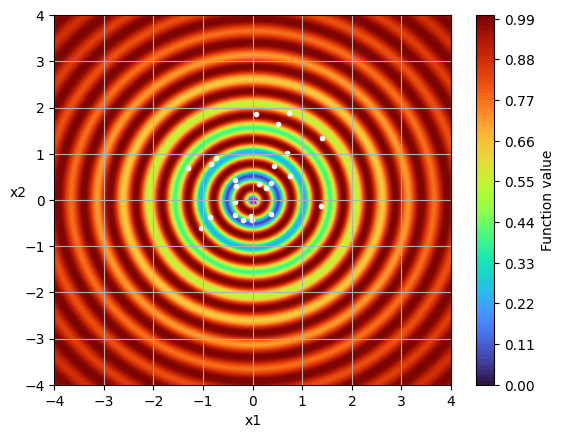

3.428523365656133e-06


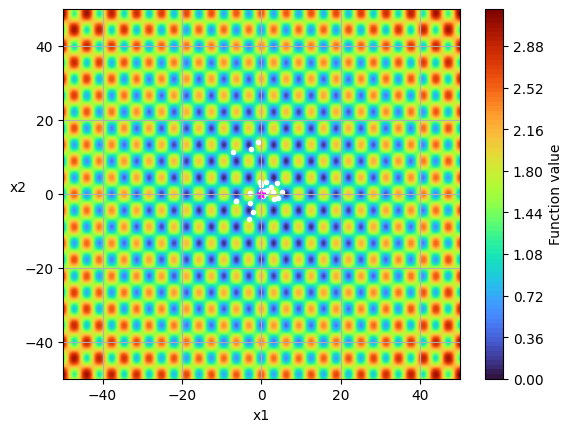

0.0014592853283694751


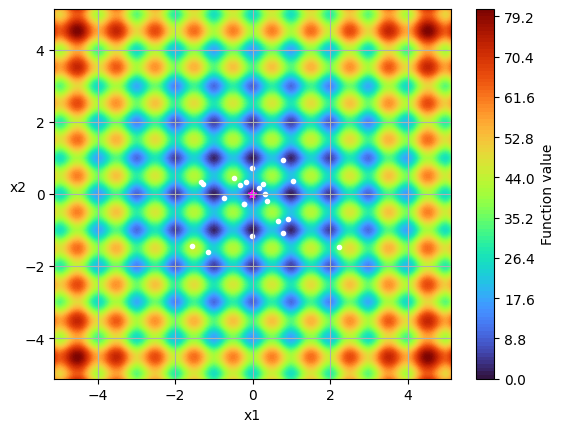

In [143]:

testing_functions = [
    DropWave(DROP_BOUNDS, DIMENSIONS),
    Griewank(GRIE_BOUNDS, DIMENSIONS),
    Rastrigin(RAST_BOUNDS, DIMENSIONS)
]

for testfun in testing_functions:
    sigma = SIGMA
    if testfun.name() == "Griewank": sigma = 2

    population = Evolution(testfun, ITERATIONS, POPULATION, PM, PC, sigma)
    plot = Plotter(testfun, PLOT_STEPS)

    best_fitnesses = []
    t = 0

    while t < population.iterations():
        t+=1

        population.fitness_func()
        population.reproduction()
        successing_population = []

        for particle in population.population():
            crossed_particle = population.crossover(particle)
            mutated_particle = population.mutation(crossed_particle)
            successing_population.append(mutated_particle)

        population.succession(successing_population)
        best_fitnesses.append(population.best_fitness().value())

    print(population.best_fitness().value())
    # plot.draw_online(population)
    plot.plot(True)
    plot.draw_points(population)

